In [1]:
import torch
import math
import numpy as np
from visdom import Visdom
import time
torch.__version__

'1.10.0+cpu'

# 4.2.1 使用Visdom在 PyTorch 中进行可视化
Visdom是Facebook在2017年发布的一款针对PyTorch的可视化工具。[官网](https://github.com/facebookresearch/visdom),visdom由于其功能简单，一般会被定义为服务器端的matplot，也就是说我们可以直接使用python的控制台模式进行开发并在服务器上执行，将一些可视化的数据传送到Visdom服务上，通过Visdom服务进行可视化

## 安装
Visdom的安装很简单，直接使用命令`pip install visdom`安装即可。
在安装完成后，使用命令`python -m visdom.server` 在本地启动服务器，启动后会提示`It's Alive! You can navigate to http://localhost:8097` 这就说明服务已经可用，我们打开浏览器，输入`http://localhost:8097` 即可看到页面。

端口8097是默认的端口可以在启动命令后加 `-port`参数指定端口，常用的参数还有 `--hostname`，`-base_url`等

## 坑
Visdom的服务在启动时会自动下载一些静态文件，这里坑就来了，因为某些无法描述的原因，导致下载会失败，比如类似这样的提示 `ERROR:root:Error 404 while downloading https://unpkg.com/layout-bin-packer@1.4.0` 就说明静态文件没有下载完全，这样有可能就会打不开或者页面中没有菜单栏，那么需要手动进行下载，这里我打包了一份正常的静态文件，直接复制到`Lib\site-packages\visdom`中即可。

如果不知道conda的环境目录在哪里，可以使用`conda env list` 查看

感谢CSDN的伙伴提供的缺失文件，原文[这里](https://blog.csdn.net/qq_36941368/article/details/82288154)

## 基本概念
### Environments
Environments的作用是对可视化区域进行分区，每个用户都会有一个叫做main的默认分区，如图所示:
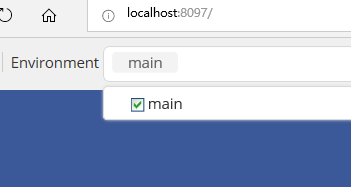
在程序指定的情况下，默认的图表都会放到这里面

## Panes
Panes是作为每一个可视化图表的容器，可以使用生成的图表，图片，文本进行填充，我们可以对Panes进行拖放，删除，调整大小和销毁等操作：
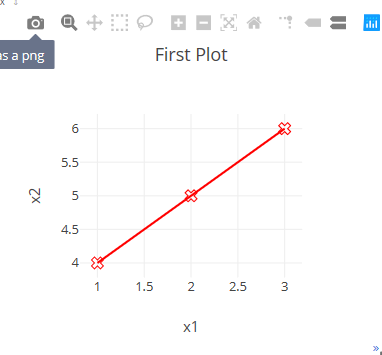
Panes和Environments是一对多的关系，即一个Environments可以包含多个Panes


### VIEW
在对Panes进行调整后，可以通过VIEW对状态进行管理：
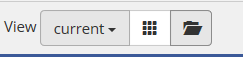

## 可视化接口
Visdom是由Plotly 提供的可视化支持，所以提供一下可视化的接口:
- vis.scatter : 2D 或 3D 散点图
- vis.line : 线图
- vis.stem : 茎叶图
- vis.heatmap : 热力图
- vis.bar : 条形图
- vis.histogram: 直方图
- vis.boxplot : 箱型图
- vis.surf : 表面图
- vis.contour : 轮廓图
- vis.quiver : 绘出二维矢量场
- vis.image : 图片
- vis.text : 文本
- vis.mesh : 网格图
- vis.save : 序列化状态

## 使用
### 绘制简单的图形
这里我们使用官方的DEMO来做样例

In [2]:
env = Visdom() 
assert env.check_connection() #测试一下链接，链接错误的话会报错

Setting up a new session...


Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "d:\pyprojectin\pytorch\venv\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "d:\pyprojectin\pytorch\venv\lib\site-packages\urllib3\util\connection.py", line 96, in create_connection
    raise err
  File "d:\pyprojectin\pytorch\venv\lib\site-packages\urllib3\util\connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] 由于目标计算机积极拒绝，无法连接。

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "d:\pyprojectin\pytorch\venv\lib\site-packages\urllib3\connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "d:\pyprojectin\pytorch\venv\lib\site-packages\urllib3\connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "d:\pyprojectin\pytorch\venv\lib\site-packages\urllib3\connection.py", line 239, in 

AssertionError: 

这里生成sin和cos两条曲线数据

In [ ]:
Y = np.linspace(0, 2 * math.pi, 70)
X = np.column_stack((np.sin(Y), np.cos(Y)))

使用茎叶图展示

In [ ]:
env.stem(
        X=X,
        Y=Y,
        opts=dict(legend=['Sine', 'Cosine'])
    )

可以通过env参数指定Environments，如果名称包含了下划线`_`那么visdom会跟根据下划线分割并自动分组

In [ ]:
envtest = Visdom(env='test_mesh')
assert envtest.check_connection()

生成一个网格图

In [ ]:
x = [0, 0, 1, 1, 0, 0, 1, 1]
y = [0, 1, 1, 0, 0, 1, 1, 0]
z = [0, 0, 0, 0, 1, 1, 1, 1]
X = np.c_[x, y, z]
i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2]
j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3]
k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6]
Y = np.c_[i, j, k]
envtest.mesh(X=X, Y=Y, opts=dict(opacity=0.5))

## 更新损失函数

在训练的时候我们每一批次都会打印一下训练的损失和测试的准确率，这样展示的图表是需要动态增加数据的，下面我们来模拟一下这种情况

In [ ]:
x,y=0,0
env2 = Visdom()
pane1= env2.line(
    X=np.array([x]),
    Y=np.array([y]),
    opts=dict(title='dynamic data'))

In [ ]:
for i in range(10):
    time.sleep(1) #每隔一秒钟打印一次数据
    x+=i
    y=(y+i)*1.5
    print(x,y)
    env2.line(
        X=np.array([x]),
        Y=np.array([y]),
        win=pane1,#win参数确认使用哪一个pane
        update='append') #我们做的动作是追加，除了追加意外还有其他方式，这里我们不做介绍了

在运行完上述程序时，切换到visdom，看看效果吧

visdom的基本用法介绍完毕，下一节介绍更加强大的 tensorboardx